In [2]:
import os
import time
import math
import json
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D


In [3]:
DATA_PATH = r'C:\Users\Lloyd Acha\Documents\ACHA_Files\Projects\Programming\DataSets\GTZAN Dataset - Music Genre Classification\Data'
AUDIO_PATH = os.path.join(DATA_PATH,'genres_original')
JSON_PATH = 'mfcc_data.json'

In [4]:
#Prepare data
data ={
    'mapping' : [],
    'mfcc' : [],
    'labels' : []
}

sr = 22050
duration = 30
segments = 5
n_mfcc = 13
n_fft = 2048
hop_len = 512
samp_p_track = sr * duration
samp_p_seg = int(samp_p_track/segments)
mfcc_p_seg = math.ceil(samp_p_seg / hop_len)

for i, (dirpath, dirname, filenames) in enumerate(os.walk(AUDIO_PATH)):
    if dirpath is not AUDIO_PATH:
        label = dirpath.split('\\')[-1]
        data['mapping'].append(label)
        print(f'Processing {label}...')
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            signal, sr = librosa.load(file_path, sr = sr)
            for s in range(segments):
                s_samp = samp_p_seg * s
                f_samp = s_samp + samp_p_seg
                
                mfcc = librosa.feature.mfcc(
                    y = signal[s_samp:f_samp], sr = sr, n_mfcc = n_mfcc, 
                    n_fft = n_fft, hop_length = hop_len)
                mfcc = mfcc.T
                if len(mfcc) == mfcc_p_seg:
                    data['mfcc'].append(mfcc.tolist())
                    data['labels'].append(i-1)
                    print(f'seg: \r{file}-{s}')
                    
with open(JSON_PATH, 'w') as fp:
    json.dump(data, fp, indent=4)

Processing blues...
blues.00000.wav-0
blues.00000.wav-1
blues.00000.wav-2
blues.00000.wav-3
blues.00000.wav-4
blues.00001.wav-0
blues.00001.wav-1
blues.00001.wav-2
blues.00001.wav-3
blues.00001.wav-4
blues.00002.wav-0
blues.00002.wav-1
blues.00002.wav-2
blues.00002.wav-3
blues.00002.wav-4
blues.00003.wav-0
blues.00003.wav-1
blues.00003.wav-2
blues.00003.wav-3
blues.00003.wav-4
blues.00004.wav-0
blues.00004.wav-1
blues.00004.wav-2
blues.00004.wav-3
blues.00004.wav-4
blues.00005.wav-0
blues.00005.wav-1
blues.00005.wav-2
blues.00005.wav-3
blues.00005.wav-4
blues.00006.wav-0
blues.00006.wav-1
blues.00006.wav-2
blues.00006.wav-3
blues.00006.wav-4
blues.00007.wav-0
blues.00007.wav-1
blues.00007.wav-2
blues.00007.wav-3
blues.00007.wav-4
blues.00008.wav-0
blues.00008.wav-1
blues.00008.wav-2
blues.00008.wav-3
blues.00008.wav-4
blues.00009.wav-0
blues.00009.wav-1
blues.00009.wav-2
blues.00009.wav-3
blues.00009.wav-4
blues.00010.wav-0
blues.00010.wav-1
blues.00010.wav-2
blues.00010.wav-3
blues.00

KeyboardInterrupt: 

In [85]:
#Load data
with open(JSON_PATH,'r') as fp:
    data = json.load(fp)



In [86]:
inputs = np.array(data['mfcc'])
targets = to_categorical(np.array(data['labels']))

In [87]:
np.array(data['mapping']).shape[0]

10

In [114]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.05)
x_train, x_eval, y_train, y_eval = train_test_split(x_train,y_train, test_size = 0.05)
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_eval = np.expand_dims(x_eval, axis=3)

In [90]:
y_train.shape

(4505, 10)

In [102]:
model = Sequential()
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(259,13,1)))
model.add(MaxPool2D((3, 3), strides=(2,2,), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(259,13,1)))
model.add(MaxPool2D((3, 3), strides=(2,2,), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (2,2),
                activation='relu',
                input_shape=(259,13,1)))
model.add(MaxPool2D((2, 2), strides=(2,2,), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(np.array(data['mapping']).shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [103]:
CP_PATH = 'checkpoints/cp-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5'
checkpoints = ModelCheckpoint(CP_PATH, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=3)
log_csv = CSVLogger('test_log.csv', separator=',', append=False)
callback_list = [checkpoints, early_stop, log_csv]

In [104]:
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, epochs = 50, 
                        callbacks=callback_list,
                        validation_data = (x_eval, y_eval))
    model.save('test_model1.h5')


Epoch 1/50
140/141 [============================>.] - ETA: 0s - loss: 1.5397 - categorical_accuracy: 0.4654
Epoch 1: val_categorical_accuracy improved from -inf to 0.39496, saving model to checkpoints\cp-01-0.39.hdf5
141/141 [==============================] - 2s 10ms/step - loss: 1.5372 - categorical_accuracy: 0.4666 - val_loss: 1.8483 - val_categorical_accuracy: 0.3950
Epoch 2/50
138/141 [============================>.] - ETA: 0s - loss: 0.9457 - categorical_accuracy: 0.6615
Epoch 2: val_categorical_accuracy improved from 0.39496 to 0.58403, saving model to checkpoints\cp-02-0.58.hdf5
141/141 [==============================] - 1s 7ms/step - loss: 0.9418 - categorical_accuracy: 0.6628 - val_loss: 1.2383 - val_categorical_accuracy: 0.5840
Epoch 3/50
139/141 [============================>.] - ETA: 0s - loss: 0.7021 - categorical_accuracy: 0.7669
Epoch 3: val_categorical_accuracy improved from 0.58403 to 0.62605, saving model to checkpoints\cp-03-0.63.hdf5
141/141 [=======================

(0.0, 6.0)

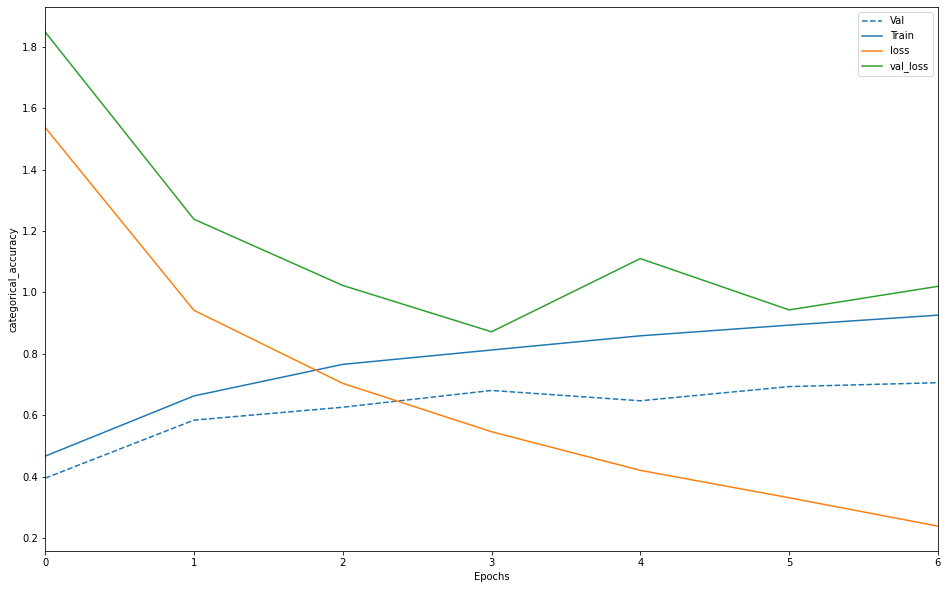

In [105]:
plt.figure(figsize=(16,10))
val = plt.plot(history.epoch, 
           history.history['val_categorical_accuracy'],
           '--', 
               label='Val')
plt.plot(history.epoch, 
         history.history['categorical_accuracy'], 
         color=val[0].get_color(), 
         label='Train')
plt.plot(history.epoch, 
         history.history['loss'], 
         label='loss')
plt.plot(history.epoch, 
         history.history['val_loss'], 
         label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('categorical_accuracy')
plt.legend()
plt.xlim([0,max(history.epoch)])

In [106]:
test_error, accuracy = model.evaluate(x_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.9468 - categorical_accuracy: 0.7120


In [113]:
x_test = np.expand_dims(x_test, axis=1)
x_test.shape

(250, 1, 1, 1, 1, 259, 13, 1)

In [116]:
pred = model.predict(x_test)
p_idx = np.argmax(pred, axis=1)
print(f'{p_idx} -> {y_test}')

[0 4 9 6 6 0 9 7 9 7 2 3 6 7 4 5 9 7 2 3 7 1 5 6 7 2 7 5 7 7 7 2 4 1 7 2 7
 1 1 9 6 4 0 2 0 8 7 7 3 2 4 8 5 2 9 3 7 3 4 1 0 8 8 8 9 8 8 3 3 7 2 7 2 1
 0 7 2 8 1 0 4 0 4 7 9 5 6 6 9 0 0 2 1 9 0 6 9 5 6 1 9 8 1 6 6 2 7 2 4 8 4
 2 7 2 8 2 4 1 7 7 2 4 1 7 7 2 4 7 3 7 2 3 5 7 2 5 4 7 6 4 0 3 9 5 6 8 5 7
 4 3 9 9 2 9 6 0 4 8 6 5 0 9 6 4 0 4 9 1 6 0 4 4 2 6 8 3 2 7 4 2 9 8 2 4 6
 7 0 8 1 3 9 0 1 6 2 4 4 5 6 2 5 7 2 3 2 9 8 1 7 3 2 8 1 8 3 7 2 2 9 7 3 9
 5 9 3 5 1 6 9 1 2 4 1 3 5 7 1 7 8 1 1 3 7 6 3 0 9 7 4 2] -> [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
